# NN Model
batchsize : epoch

256 : 5 ロスは下がるが１の割合がやばい、多分catboost の予測を汲み取りすぎる

32 : 2 0.52  cv 0.577 NN_4

48 : 2 0.64, 1が多い

24 : 2 0.57 cvが高い　NN_3　

40 : 

1 : 1

0.55 NN_1

model 4
256 : 5 0.58

256 : 4 0.569 cv 0.5777

32 : 2 

512 : 5  0.5391672547635851 cv score :  0.5798109640831758 NN4_2

過学習しない？

In [1]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import sklearn
from Functions import prepro, NNModel
import warnings

import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow.keras.callbacks import EarlyStopping


random.seed(random.randint(0, 10000))

pd.set_option("display.max_columns", 1000)
pd.set_option("display.max_rows", 1000)
warnings.filterwarnings('ignore')

In [2]:
X = pd.concat([pd.read_csv("../MakeFeaturesForStacking/Train/train_lgbm_feature_{}.csv".format(i)) for i in range(1, 31)], axis=1)
test_X = pd.concat([pd.read_csv("../MakeFeaturesForStacking/Test/test_lgbm_feature_{}.csv".format(i)) for i in range(1, 31)], axis=1)
print(X.shape)
print(test_X.shape)

(132250, 30)
(28340, 30)


In [3]:
y = pd.read_csv("../../data/Processed/train2.csv", usecols=["y"]).values
y = np.append(y, 1-y)
print(y.shape)

(132250,)


In [4]:
# 全データを5つに分割
random.seed(random.randint(0, 10000))
SIZE = X.shape[0]
K = 5

folds = prepro.make_kfolds(SIZE, K)
print(len(folds))
for i, fold in enumerate(folds):
    print("fold ", i+1, " size is ", len(fold))
    
    
if SIZE != len(set(sum(folds, []))):
    print("error is occuring in spliting")
else :
    print("successfully split")

5
fold  1  size is  26450
fold  2  size is  26450
fold  3  size is  26450
fold  4  size is  26450
fold  5  size is  26450
successfully split


In [5]:
THRESHOLD = 0.50
models = []
cv_scores = []
temp = 0
train_pred = []

all_indices = sum(folds, [])
for i in range(K):
    print("======================== fold {} ========================".format(i+1))
    valid_indices = folds[i]
    train_indices = list(set(all_indices) - set(valid_indices))
    # print("train ", len(train_indices), " , valid ", len(valid_indices))
    train_X = X.iloc[train_indices].values
    train_y = y[train_indices].reshape(-1, 1)
    valid_X = X.iloc[valid_indices].values
    valid_y = y[valid_indices].reshape(-1, 1)
    
    
    model = NNModel.make_model4(X, test_X)
    

    
    
    

    cb = EarlyStopping(monitor='val_loss', patience=1)

    model.fit(
        train_X, 
        train_y,
        batch_size=256,
        epochs=10,
        verbose=1,
        shuffle=True,
        #callbacks=[cb],
        validation_data=(valid_X, valid_y),
    )
    
    pred = model.predict(valid_X)
    
    train_pred.append(pred)
    temp += np.sum(pred)
    
    pred = np.where(pred < THRESHOLD, 0, 1)
    score = accuracy_score(pred, valid_y)
    
    models.append(model)
    cv_scores.append(score)
    
    
print("cv score : ", np.mean(cv_scores))    
print("cv ratio : ", temp / SIZE)

======================== fold 1 ========================
Train on 105800 samples, validate on 26450 samples
Epoch 1/6
105800/105800 [==============================] - 2s 19us/sample - loss: 0.6930 - val_loss: 0.6902
Epoch 2/6
105800/105800 [==============================] - 1s 9us/sample - loss: 0.6893 - val_loss: 0.6863
Epoch 3/6
105800/105800 [==============================] - 1s 10us/sample - loss: 0.6861 - val_loss: 0.6839
Epoch 4/6
105800/105800 [==============================] - 1s 10us/sample - loss: 0.6838 - val_loss: 0.6831
Epoch 5/6
105800/105800 [==============================] - 1s 10us/sample - loss: 0.6823 - val_loss: 0.6797
Epoch 6/6
105800/105800 [==============================] - 1s 10us/sample - loss: 0.6815 - val_loss: 0.6792
======================== fold 2 ========================
Train on 105800 samples, validate on 26450 samples
Epoch 1/6
105800/105800 [==============================] - 2s 15us/sample - loss: 0.6937 - val_loss: 0.6919
Epoch 2/6
105800/105800 [====

0.5074817988598271
0.5305990387372089
0.4999044801958363
0.49860417723403316
0.536757929659933
0.5146694573703247


array([[<AxesSubplot:title={'center':'pred'}>]], dtype=object)

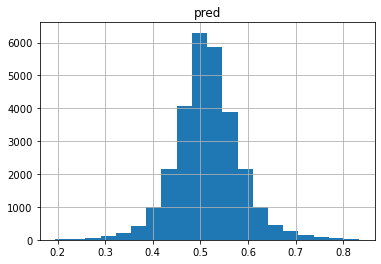

In [6]:
preds = []
test_X = test_X.values

for i in range(K):
    model = models[i]
    pred = model.predict(test_X, batch_size=128).reshape(-1, )
    preds.append(pred)
    print(np.sum(pred) / pred.shape[0])
    
preds = np.array(preds)
preds = np.mean(preds, axis=0)
print(np.sum(preds) / preds.shape[0])


temp = pd.DataFrame({"pred":preds})
temp.hist(bins=20)

In [7]:
preds = np.where(preds < THRESHOLD, 0, 1)
print(np.sum(preds) / preds.shape[0])

submit_df = pd.DataFrame({'y': preds})
submit_df.index.name = 'id'
#submit_df.to_csv('../Submissions/submission_NN_lgbm_stacking_model4_1_{}.csv'.format(K))

0.5956245589273113


In [8]:
while True:
    X = pd.concat([pd.read_csv("../MakeFeaturesForStacking/Train/train_lgbm_feature_{}.csv".format(i)) for i in range(1, 31)], axis=1)
    test_X = pd.concat([pd.read_csv("../MakeFeaturesForStacking/Test/test_lgbm_feature_{}.csv".format(i)) for i in range(1, 31)], axis=1)
    y = pd.read_csv("../../data/Processed/train2.csv", usecols=["y"]).values
    y = np.append(y, 1-y)
    # 全データを5つに分割
    random.seed(random.randint(0, 10000))
    SIZE = X.shape[0]
    K = 5

    folds = prepro.make_kfolds(SIZE, K)

    THRESHOLD = 0.50
    models = []
    cv_scores = []
    temp = 0
    train_pred = []

    all_indices = sum(folds, [])
    for i in range(K):
        print("======================== fold {} ========================".format(i+1))
        valid_indices = folds[i]
        train_indices = list(set(all_indices) - set(valid_indices))
        # print("train ", len(train_indices), " , valid ", len(valid_indices))
        train_X = X.iloc[train_indices].values
        train_y = y[train_indices].reshape(-1, 1)
        valid_X = X.iloc[valid_indices].values
        valid_y = y[valid_indices].reshape(-1, 1)


        model = NNModel.make_model4(X, test_X)






        cb = EarlyStopping(monitor='val_loss', patience=1)

        model.fit(
            train_X, 
            train_y,
            batch_size=256,
            epochs=6,
            verbose=6,
            shuffle=True,
            #callbacks=[cb],
            validation_data=(valid_X, valid_y),
        )

        pred = model.predict(valid_X)

        train_pred.append(pred)
        temp += np.sum(pred)

        pred = np.where(pred < THRESHOLD, 0, 1)
        score = accuracy_score(pred, valid_y)

        models.append(model)
        cv_scores.append(score)


    print("cv score : ", np.mean(cv_scores))    
    print("cv ratio : ", temp / SIZE)

    preds = []
    test_X = test_X.values

    for i in range(K):
        model = models[i]
        pred = model.predict(test_X, batch_size=256).reshape(-1, )
        preds.append(pred)
        print(np.sum(pred) / pred.shape[0])

    preds = np.array(preds)
    preds = np.mean(preds, axis=0)
    print(np.sum(preds) / preds.shape[0])


    temp = pd.DataFrame({"pred":preds})
    #temp.hist(bins=20)

    preds = np.where(preds < THRESHOLD, 0, 1)
    print(np.sum(preds) / preds.shape[0])

    submit_df = pd.DataFrame({'y': preds})
    submit_df.index.name = 'id'
    submit_df.to_csv('../Submissions/submission_lgbm_NN_stacking_model4_1_{}.csv'.format(K))
    if np.sum(preds) / preds.shape[0] < 0.550 and 0.540 < np.sum(preds) / preds.shape[0]:
        break

======================== fold 1 ========================
Train on 105800 samples, validate on 26450 samples
Epoch 1/6
Epoch 2/6
Epoch 3/6
Epoch 4/6
Epoch 5/6
Epoch 6/6
======================== fold 2 ========================
Train on 105800 samples, validate on 26450 samples
Epoch 1/6
Epoch 2/6
Epoch 3/6
Epoch 4/6
Epoch 5/6
Epoch 6/6
======================== fold 3 ========================
Train on 105800 samples, validate on 26450 samples
Epoch 1/6
Epoch 2/6
Epoch 3/6
Epoch 4/6
Epoch 5/6
Epoch 6/6
======================== fold 4 ========================
Train on 105800 samples, validate on 26450 samples
Epoch 1/6
Epoch 2/6
Epoch 3/6
Epoch 4/6
Epoch 5/6
Epoch 6/6
======================== fold 5 ========================
Train on 105800 samples, validate on 26450 samples
Epoch 1/6
Epoch 2/6
Epoch 3/6
Epoch 4/6
Epoch 5/6
Epoch 6/6
cv score :  0.5533232514177693
cv ratio :  0.489297066989603
0.536293321608151
0.5054383573350388
0.4897727993229534
0.47499572710832744
0.49785890222521173
0.5